# Diffusion model for clutter denoising

## Initialization

### Imports

In [1]:
import os
import math
import torch
import wandb
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from torch import einsum
from models.unet import *
import torch.optim as optim
from utils.trainer import *
from torch.optim import Adam
from utils.plotters import *
from utils.inference import *
from models.diffusion import *
from dataset.radardata import *
import torch.nn.functional as F
import matplotlib.pyplot as plt
from types import SimpleNamespace
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split

### Define device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Initialiaze W&B + config

In [3]:
wandb.init(
    project="Radar-diffusion",
    name="exp_0",
    config={
        "SNR": 10,
        "CNR": 15,
        "max_lr": 1e-3,
        "beta_end": 0.02,
        "final_lr": 1e-5,
        "num_heads": 8,
        "beta_start": 1e-4,
        "num_layers": 6,
        "batch_size": 16,
        "num_epochs": 600,
        "noise_steps": 2000,
        "num_workers": 4,
        "weight_decay": 1e-4,
        "warmup_steps": 4000,
        "dataset_size": 500,
        "time_emb_dim": 256,
        "learning_rate": 1e-5,        
        "scheduler_type": "linear",
    },
)
config = wandb.config

wandb: Currently logged in as: ari-granevich. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


## dataset prep

In [4]:
train_loader, val_loader, norm_train_loader, norm_val_loader, train_dataset_with_targets, norm_train_dataset, norm_val_dataset = prep_dataset(config)

Normalizing dataset: 100%|██████████| 55/55 [00:00<00:00, 778.06it/s]


## Dataset Visualization

In [5]:
visualize_sample(train_dataset_with_targets, sample_index=1, plot_here=False, save_to_wandb=True) # regular dataset.
visualize_sample(norm_train_dataset, sample_index=1, plot_here=False, save_to_wandb=True) # same dataset, after normalization.
compare_nu_scnr(nu_values=[0.01, 0.1, 1], scnr_values=[-20, -10, 0, 10, 20], radar_dataset_class=RadarDataset, plot_here=False, save_to_wandb=True)

SCNR (dB): tensor(-5.1352)
SCNR (dB): tensor(-5.1352)


## train

In [6]:
train_loader = norm_train_loader
val_loader = norm_val_loader
cond_unet = ConditionalUNet(in_channels=4, out_channels=2, time_emb_dim=config.time_emb_dim).to(device)
cond_diffusion = ConditionalDiffusion(model=cond_unet, scheduler_type=config.scheduler_type, T=config.noise_steps, beta_start=config.beta_start, beta_end=config.beta_end).to(device)
optimizer = torch.optim.Adam(cond_diffusion.parameters(), config.learning_rate)
num_epochs = config.num_epochs
best_val_loss = float('inf')
best_mse_loss = float('inf')

In [7]:
train_losses = []
val_losses = []
val_psnrs = []
val_mses = []
for epoch in range(num_epochs):
    train_loss = train_one_epoch(cond_diffusion, train_loader, optimizer, device)
    val_loss, gen_mse, gen_psnr = validate(cond_diffusion, val_loader, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if gen_psnr is not None:
        val_psnrs.append(gen_psnr)
    if gen_mse is not None:
        val_mses.append(gen_mse)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f} | Val Loss = {val_loss:.4f}")
    if gen_mse is not None and gen_psnr is not None:
        print(f"   [Generation Metrics] MSE: {gen_mse:.4f} | PSNR: {gen_psnr:.2f} dB")

    if gen_mse < best_mse_loss:
        best_mse_loss = gen_mse
        torch.save(cond_diffusion.state_dict(), "new_diffusion.pth")
        print("   --> Best model saved.")

    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "gen_mse": gen_mse if gen_mse is not None else float('nan'),
        "gen_psnr": gen_psnr if gen_psnr is not None else float('nan')
    })

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

if len(val_psnrs) > 0:
    plt.figure(figsize=(8,6))
    plt.plot(val_psnrs, label="Val PSNR (dB)")
    plt.xlabel("Epochs")
    plt.ylabel("PSNR")
    plt.title("Validation PSNR over epochs")
    plt.legend()
    plt.show()

/Users/arigranevich/Developer/Research/Diffusion/finalDiffusion/utils/inference.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cond_diffusion.load_state_dict(torch.loa

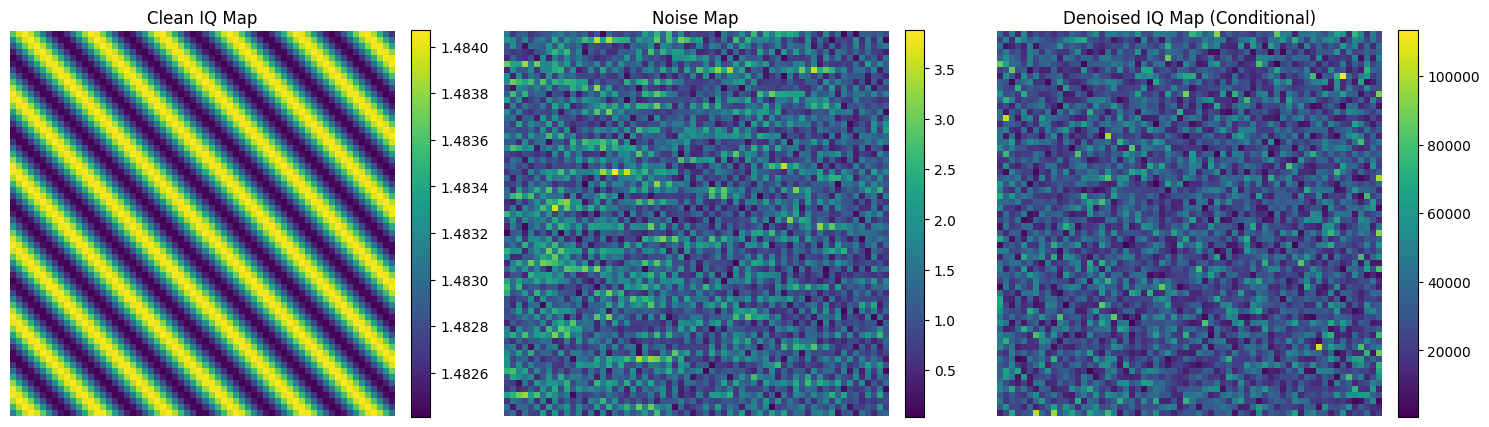

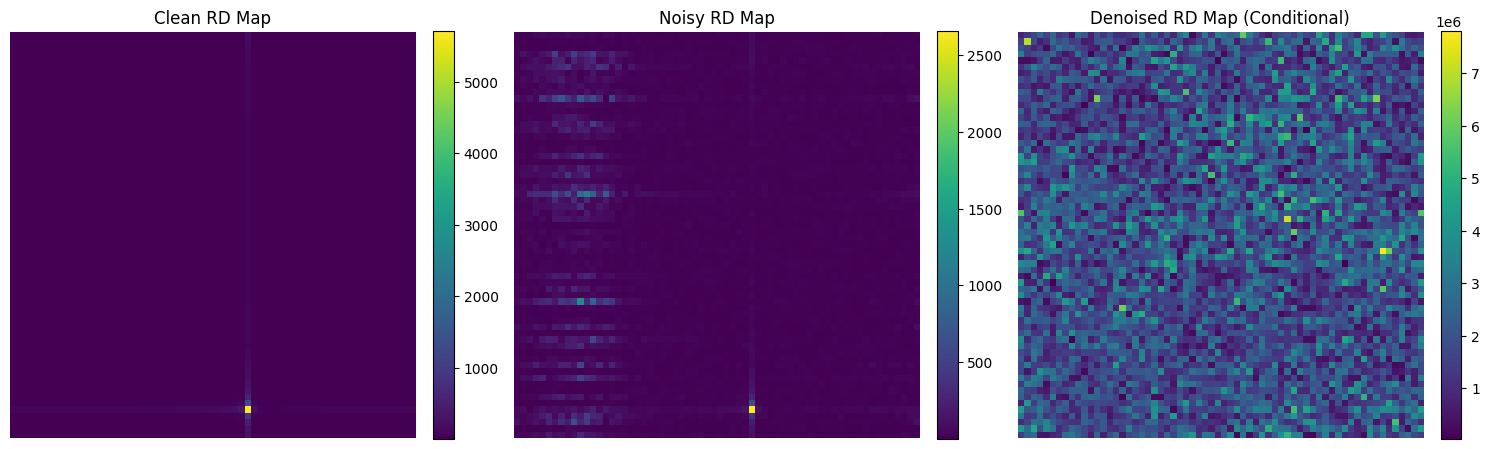

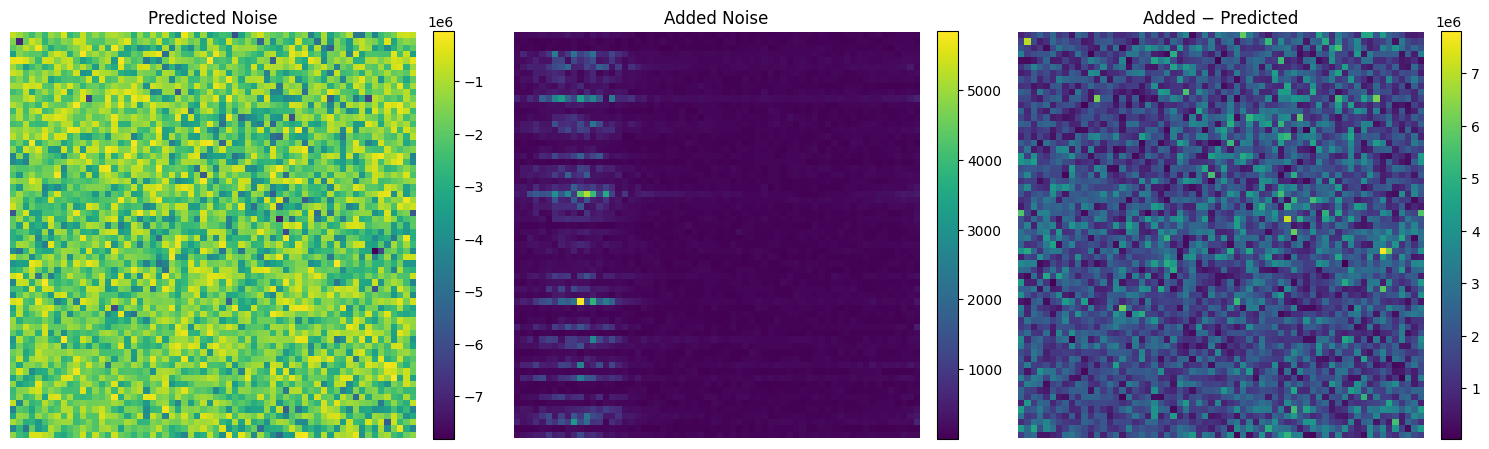

In [8]:
run_inference(cond_diffusion , norm_val_dataset, '/Users/arigranevich/Developer/Research/Diffusion/finalDiffusion/new_diffusion.pth', device)